Found categories: 15
['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


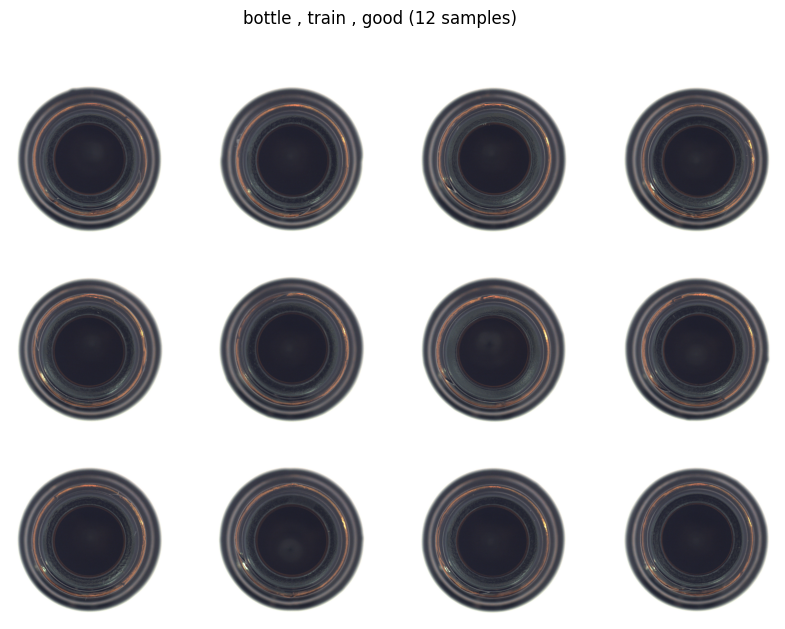

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

DATASET_PATH = r"C:\Users\parth\OneDrive\Desktop\MVTech Dataset"

# list categories
categories = sorted([
    d for d in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, d))
])

print("Found categories:", len(categories))
print(categories)

# choose one category
category = "bottle"
good_dir = os.path.join(DATASET_PATH, category, "train", "good")

imgs = [f for f in os.listdir(good_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))][:12]

plt.figure(figsize=(10, 7))
for i, name in enumerate(imgs):
    img = Image.open(os.path.join(good_dir, name))
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle(f"{category} , train , good (12 samples)")
plt.show()


In [2]:
import os

DATASET_PATH = r"C:\Users\parth\OneDrive\Desktop\MVTech Dataset"
category = "bottle"

cat_path = os.path.join(DATASET_PATH, category)

train_good = os.path.join(cat_path, "train", "good")
test_path  = os.path.join(cat_path, "test")
gt_path    = os.path.join(cat_path, "ground_truth")

def count_images(folder):
    if not os.path.exists(folder):
        return 0
    exts = (".png", ".jpg", ".jpeg", ".bmp")
    return sum(1 for f in os.listdir(folder) if f.lower().endswith(exts))

print("CATEGORY:", category)
print("Train good images:", count_images(train_good))

# test subfolders (good + defect types)
test_subfolders = sorted([d for d in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, d))])
print("\nTest subfolders:", test_subfolders)

test_counts = {}
for d in test_subfolders:
    test_counts[d] = count_images(os.path.join(test_path, d))

print("\nTest image counts:")
for k, v in test_counts.items():
    print(f"  {k:20s} {v}")

# ground truth masks exist only for defect types, not for "good"
gt_subfolders = sorted([d for d in os.listdir(gt_path) if os.path.isdir(os.path.join(gt_path, d))])
print("\nGround truth subfolders:", gt_subfolders)

gt_counts = {}
for d in gt_subfolders:
    gt_counts[d] = count_images(os.path.join(gt_path, d))

print("\nGround truth mask counts:")
for k, v in gt_counts.items():
    print(f"  {k:20s} {v}")


CATEGORY: bottle
Train good images: 209

Test subfolders: ['broken_large', 'broken_small', 'contamination', 'good']

Test image counts:
  broken_large         20
  broken_small         22
  contamination        21
  good                 20

Ground truth subfolders: ['broken_large', 'broken_small', 'contamination']

Ground truth mask counts:
  broken_large         20
  broken_small         22
  contamination        21


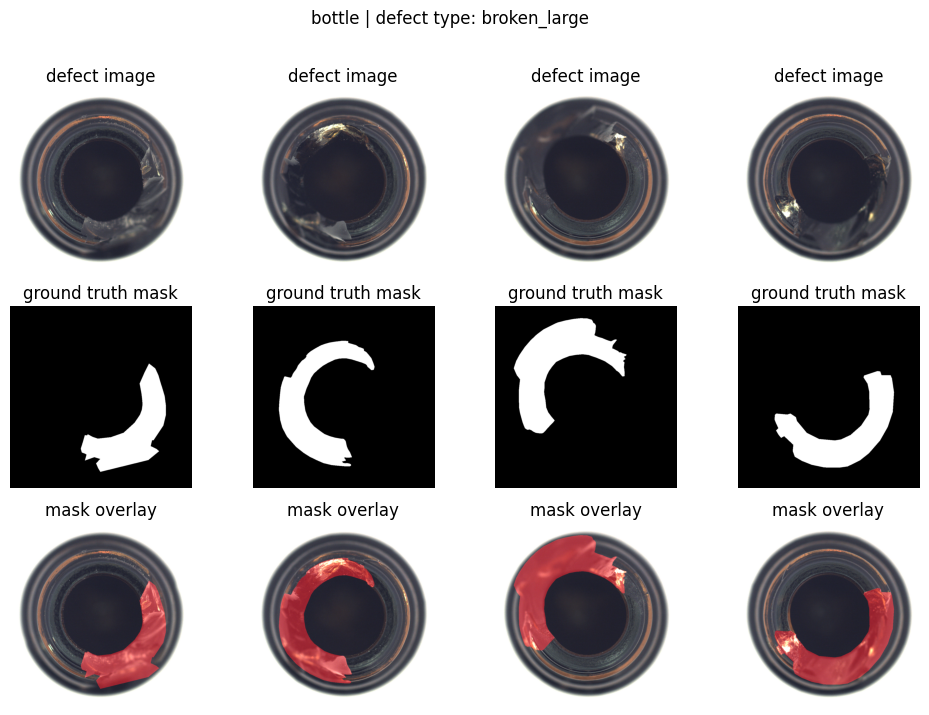

In [3]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

DATASET_PATH = r"C:\Users\parth\OneDrive\Desktop\MVTech Dataset"
category = "bottle"

cat_path = os.path.join(DATASET_PATH, category)
test_path = os.path.join(cat_path, "test")
gt_path = os.path.join(cat_path, "ground_truth")

# pick a defect type (first non-good folder)
defect_types = [d for d in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, d)) and d != "good"]
defect_type = sorted(defect_types)[0]

# pick random defective images
defect_dir = os.path.join(test_path, defect_type)
mask_dir = os.path.join(gt_path, defect_type)

def_imgs = sorted([f for f in os.listdir(defect_dir) if f.lower().endswith(".png")])
sample = random.sample(def_imgs, k=min(4, len(def_imgs)))

plt.figure(figsize=(12, 8))
for i, fn in enumerate(sample):
    img = Image.open(os.path.join(defect_dir, fn)).convert("RGB")
    mask_name = fn.replace(".png", "_mask.png")
    mask_path = os.path.join(mask_dir, mask_name)
    mask = Image.open(mask_path).convert("L") if os.path.exists(mask_path) else None

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title("defect image")
    plt.axis("off")

    if mask is not None:
        plt.subplot(3, 4, i+1+4)
        plt.imshow(mask, cmap="gray")
        plt.title("ground truth mask")
        plt.axis("off")

        # overlay
        plt.subplot(3, 4, i+1+8)
        img_np = np.array(img).astype(np.float32)
        mask_np = (np.array(mask) > 0).astype(np.float32)
        overlay = img_np.copy()
        overlay[..., 0] = np.clip(overlay[..., 0] + 120 * mask_np, 0, 255)  # highlight in red channel
        plt.imshow(overlay.astype(np.uint8))
        plt.title("mask overlay")
        plt.axis("off")

plt.suptitle(f"{category} | defect type: {defect_type}")
plt.show()


In [4]:
import os
import random
from collections import Counter

DATASET_PATH = r"C:\Users\parth\OneDrive\Desktop\MVTech Dataset"
CATEGORIES = ["bottle", "cable", "hazelnut"]

def list_images(folder):
    exts = (".png", ".jpg", ".jpeg", ".bmp")
    if not os.path.exists(folder):
        return []
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]

samples = []  # (img_path, label, category, subtype)

for cat in CATEGORIES:
    cat_path = os.path.join(DATASET_PATH, cat)

    # label 0: good images from train/good
    good_dir = os.path.join(cat_path, "train", "good")
    for p in list_images(good_dir):
        samples.append((p, 0, cat, "good"))

    # label 1: defect images from test/<defect_type> excluding 'good'
    test_dir = os.path.join(cat_path, "test")
    for defect_type in os.listdir(test_dir):
        sub = os.path.join(test_dir, defect_type)
        if defect_type == "good" or (not os.path.isdir(sub)):
            continue
        for p in list_images(sub):
            samples.append((p, 1, cat, defect_type))

print("Total samples:", len(samples))

print("\nLabel counts (0=good, 1=defect):")
print(dict(Counter([s[1] for s in samples])))

print("\nCategory counts:")
print(dict(Counter([s[2] for s in samples])))

print("\nDefect subtype counts (only label=1):")
subtype_counts = Counter([s[3] for s in samples if s[1] == 1])
for k, v in subtype_counts.most_common():
    print(f"  {k:20s} {v}")

# Split
random.seed(42)
random.shuffle(samples)

val_ratio = 0.2
val_size = int(len(samples) * val_ratio)

val_samples = samples[:val_size]
train_samples = samples[val_size:]

print("\nTrain size:", len(train_samples))
print("Val size:", len(val_samples))

print("\nTrain label counts:", dict(Counter([s[1] for s in train_samples])))
print("Val label counts:", dict(Counter([s[1] for s in val_samples])))


Total samples: 1049

Label counts (0=good, 1=defect):
{0: 824, 1: 225}

Category counts:
{'bottle': 272, 'cable': 316, 'hazelnut': 461}

Defect subtype counts (only label=1):
  broken_small         22
  contamination        21
  broken_large         20
  crack                18
  hole                 18
  cut                  17
  print                17
  cut_inner_insulation 14
  bent_wire            13
  cable_swap           12
  missing_cable        12
  combined             11
  cut_outer_insulation 10
  missing_wire         10
  poke_insulation      10

Train size: 840
Val size: 209

Train label counts: {0: 653, 1: 187}
Val label counts: {0: 171, 1: 38}
